In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import pearsonr
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
london_air_df = pd.read_csv('london-air-quality.csv')
london_air_df.head()

,date,pm25,pm10,o3,no2,so2,co
0,2024/10/1,29,14,27,14,,1
1,2024/10/2,33,19,26,22,,2
2,2024/10/3,35,18,29,31,,3
3,2024/10/4,52,17,30,23,,2
4,2024/10/5,53,13,20,10,,1


In [3]:
london_air_df['date']= pd.to_datetime(london_air_df['date'])

In [4]:
london_air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3928 entries, 0 to 3927
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3928 non-null   datetime64[ns]
 1    pm25   3928 non-null   object        
 2    pm10   3928 non-null   object        
 3    o3     3928 non-null   object        
 4    no2    3928 non-null   object        
 5    so2    3928 non-null   object        
 6    co     3928 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 214.9+ KB


In [5]:
london_air_df.describe()

C:\Users\dhind\AppData\Local\Temp/ipykernel_22828/847876256.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  london_air_df.describe()


,date,pm25,pm10,o3,no2,so2,co
count,3928,3928,3928,3928,3928,3928,3928
unique,3928,143,69,77,82,22,19
top,2024-10-01 00:00:00,52,19,27,20,,3
freq,1,105,208,222,119,876,588
first,2013-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2024-10-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
london_air_df["date"].max()

Timestamp('2024-10-06 00:00:00')

In [7]:
london_air_df["date"].min()

Timestamp('2013-12-31 00:00:00')

In [8]:
london_air_df=london_air_df[(london_air_df['date'] > '2016-03-10') & (london_air_df['date'] < '2024-01-01')]

In [9]:
from datetime import datetime, timedelta
existing_dates = set(london_air_df['date'])
start_date = datetime(2016, 3, 10)
end_date = datetime(2024, 1, 1)
all_dates = {start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)}

missing_dates = sorted(all_dates - existing_dates)
print("Missing Dates:")
for date in missing_dates:
    print(date.strftime('%Y-%m-%d'))

Missing Dates:
2016-03-10
2017-09-06
2019-12-30
2020-03-30
2024-01-01


5 missing dates in London air quality data, we will drop the missing values

In [10]:
london_air_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2849 entries, 280 to 3921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2849 non-null   datetime64[ns]
 1    pm25   2849 non-null   object        
 2    pm10   2849 non-null   object        
 3    o3     2849 non-null   object        
 4    no2    2849 non-null   object        
 5    so2    2849 non-null   object        
 6    co     2849 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 178.1+ KB


In [11]:
london_air_df.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co'], dtype='object')

In [12]:
columns_to_convert = [' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']

def convert_selected_columns(df, columns):
    for col in columns:
        if col in df.columns:
            # Replace blank or space values with NaN
            df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)
            
            # Convert the column to int, coercing errors
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

london_air_df = convert_selected_columns(london_air_df, columns_to_convert)
london_air_df.head()

,date,pm25,pm10,o3,no2,so2,co
280,2023-10-01,46.0,19.0,17.0,21.0,NaN,2.0
281,2023-10-02,48.0,14.0,23.0,19.0,NaN,2.0
282,2023-10-03,23.0,12.0,25.0,23.0,NaN,1.0
283,2023-10-04,22.0,13.0,29.0,25.0,NaN,1.0
284,2023-10-05,30.0,15.0,27.0,20.0,NaN,2.0


In [13]:
london_air_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2849 entries, 280 to 3921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2849 non-null   datetime64[ns]
 1    pm25   2845 non-null   float64       
 2    pm10   2845 non-null   float64       
 3    o3     2842 non-null   float64       
 4    no2    2845 non-null   float64       
 5    so2    2148 non-null   float64       
 6    co     2680 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 178.1 KB


In [14]:
london_air_df.isnull().sum()

date       0
 pm25      4
 pm10      4
 o3        7
 no2       4
 so2     701
 co      169
dtype: int64

In [15]:
london_air_df.describe()

,pm25,pm10,o3,no2,so2,co
count,2845.000000,2845.000000,2842.000000,2845.000000,2148.000000,2680.000000
mean,56.362039,23.559930,25.050317,30.483304,3.250000,4.478731
std,21.541794,9.861043,9.961697,14.791596,2.558013,2.798495
min,13.000000,4.000000,1.000000,3.000000,1.000000,1.000000
25%,42.000000,17.000000,19.000000,19.000000,1.000000,2.000000
50%,53.000000,22.000000,25.000000,28.000000,3.000000,4.000000
75%,66.000000,28.000000,30.000000,41.000000,4.000000,6.000000
max,177.000000,89.000000,91.000000,92.000000,27.000000,19.000000


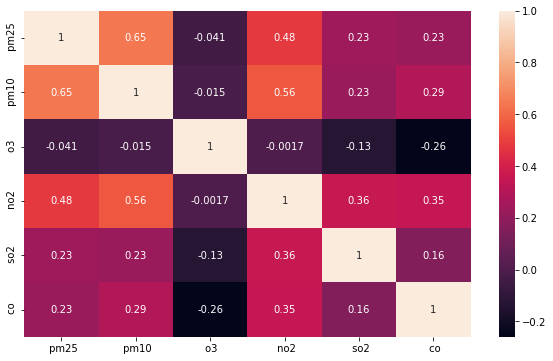

In [16]:
# Correlation matrix
plt.figure(figsize=(10,6))
correlation_matrix = london_air_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [17]:
london_air_df.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co'], dtype='object')

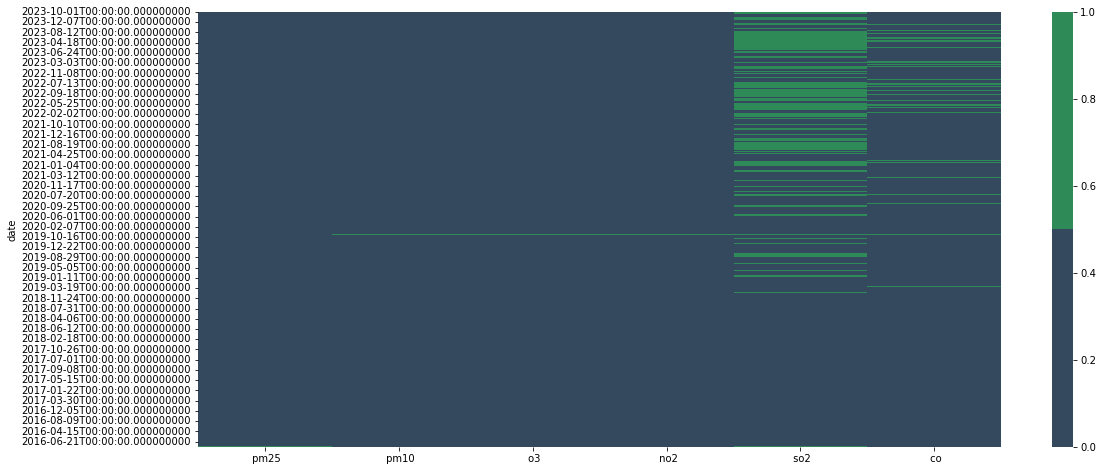

In [18]:
plt.figure(figsize=(18,8))

colours = ['#34495E', 'seagreen'] 
sns.heatmap(london_air_df.set_index('date').isnull(), cmap=sns.color_palette(colours))
plt.show()

***The green highlighted lines are the missing values***

In [19]:
# Specify the columns to fill NaN values
columns_to_fill = [' so2', ' co']

# Function to fill NaN values based on month and year average
def fill_na_with_group_mean(df, date_col, columns):
    # Extract year and month from the date column
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    
    # Group by year and month and calculate the mean for specified columns
    monthly_means = df.groupby(['year', 'month'])[columns].mean().reset_index()
    
    # Fill NaN values using the monthly means
    for col in columns:
        for index, row in monthly_means.iterrows():
            mask = (df['year'] == row['year']) & (df['month'] == row['month'])
            df.loc[mask, col] = df.loc[mask, col].fillna(row[col])
    
    # Drop the temporary year and month columns
    df.drop(['year', 'month'], axis=1, inplace=True)
    
    return df

# Apply the function
london_air_df = fill_na_with_group_mean(london_air_df, 'date', columns_to_fill)
london_air_df.head()

,date,pm25,pm10,o3,no2,so2,co
280,2023-10-01,46.0,19.0,17.0,21.0,1.357143,2.0
281,2023-10-02,48.0,14.0,23.0,19.0,1.357143,2.0
282,2023-10-03,23.0,12.0,25.0,23.0,1.357143,1.0
283,2023-10-04,22.0,13.0,29.0,25.0,1.357143,1.0
284,2023-10-05,30.0,15.0,27.0,20.0,1.357143,2.0


In [20]:
london_air_df.isnull().sum()

date      0
 pm25     4
 pm10     4
 o3       7
 no2      4
 so2     31
 co       0
dtype: int64

In [21]:
london_air_df.describe()

,pm25,pm10,o3,no2,so2,co
count,2845.000000,2845.000000,2842.000000,2845.000000,2818.000000,2849.000000
mean,56.362039,23.559930,25.050317,30.483304,2.909067,4.352308
std,21.541794,9.861043,9.961697,14.791596,2.373388,2.780400
min,13.000000,4.000000,1.000000,3.000000,1.000000,1.000000
25%,42.000000,17.000000,19.000000,19.000000,1.000000,2.000000
50%,53.000000,22.000000,25.000000,28.000000,2.000000,4.000000
75%,66.000000,28.000000,30.000000,41.000000,4.000000,6.000000
max,177.000000,89.000000,91.000000,92.000000,27.000000,19.000000


In [22]:
london_air_df.dropna(inplace=True)

***Maximum 31 missing values in Air Quality data for the So2 component data***
* Since the number of missing values is very small, we will be dropping these values

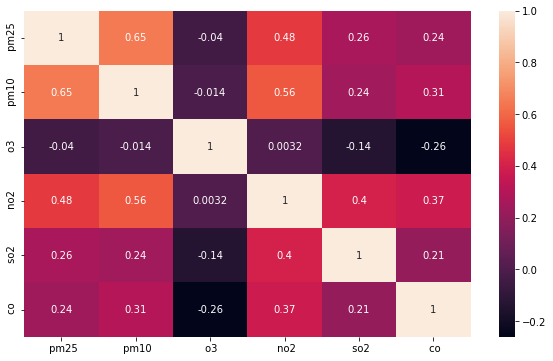

In [23]:
# Correlation matrix
plt.figure(figsize=(10,6))
correlation_matrix = london_air_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

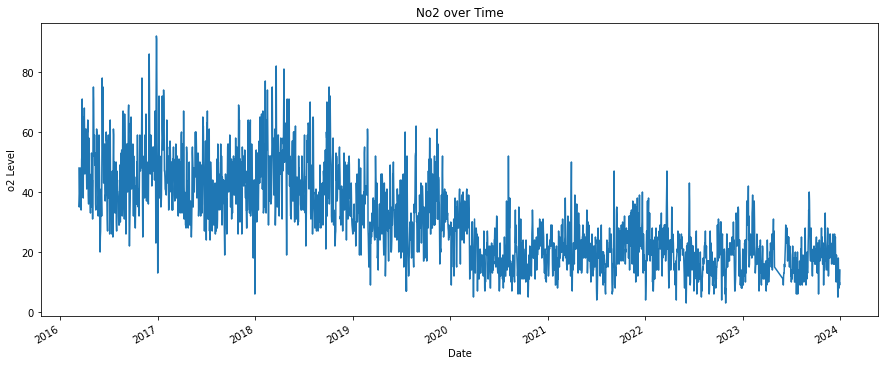

In [24]:
# Time series plot
plt.figure(figsize=(15,6))
london_air_df.set_index('date')[' no2'].plot()
plt.title('No2 over Time')
plt.xlabel('Date')
plt.ylabel('o2 Level')
plt.show()

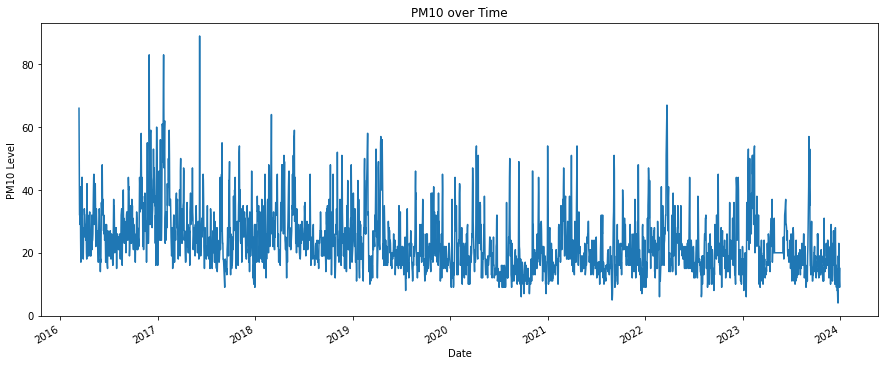

In [25]:
# Time series plot
plt.figure(figsize=(15,6))
london_air_df.set_index('date')[' pm10'].plot()
plt.title('PM10 over Time')
plt.xlabel('Date')
plt.ylabel('PM10 Level')
plt.show()

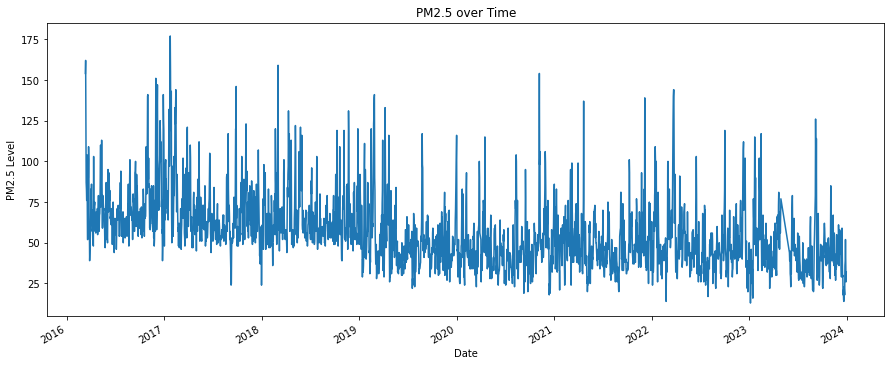

In [26]:
# Time series plot
plt.figure(figsize=(15,6))
london_air_df.set_index('date')[' pm25'].plot()
plt.title('PM2.5 over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.show()

In [27]:
london_air_df.isnull().sum()

date     0
 pm25    0
 pm10    0
 o3      0
 no2     0
 so2     0
 co      0
dtype: int64

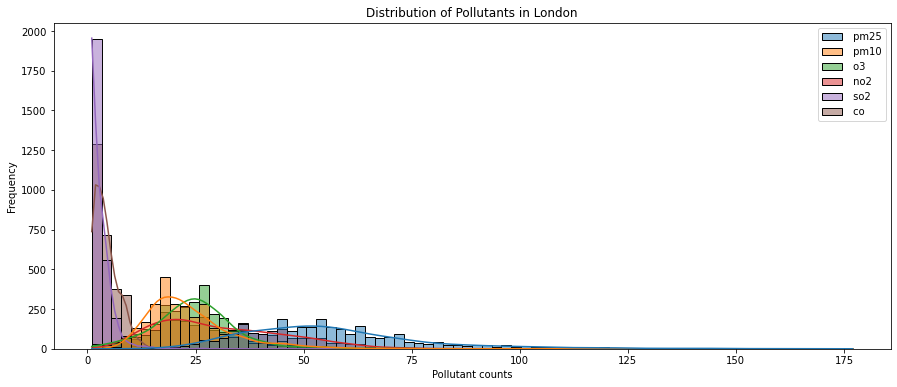

In [28]:
plt.figure(figsize=(15, 6))
sns.histplot(london_air_df, kde=True)
plt.title(f'Distribution of Pollutants in London')
plt.xlabel('Pollutant counts')
plt.ylabel('Frequency')
plt.show()

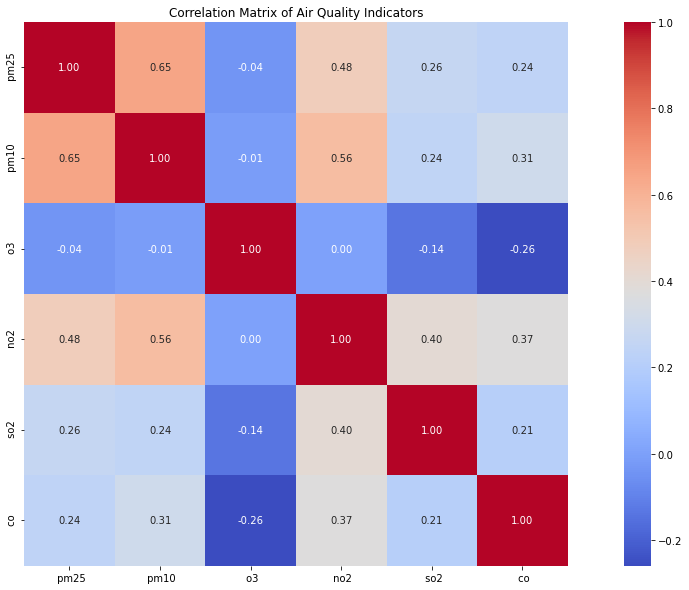

In [29]:
correlation_matrix = london_air_df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Air Quality Indicators')
plt.show()

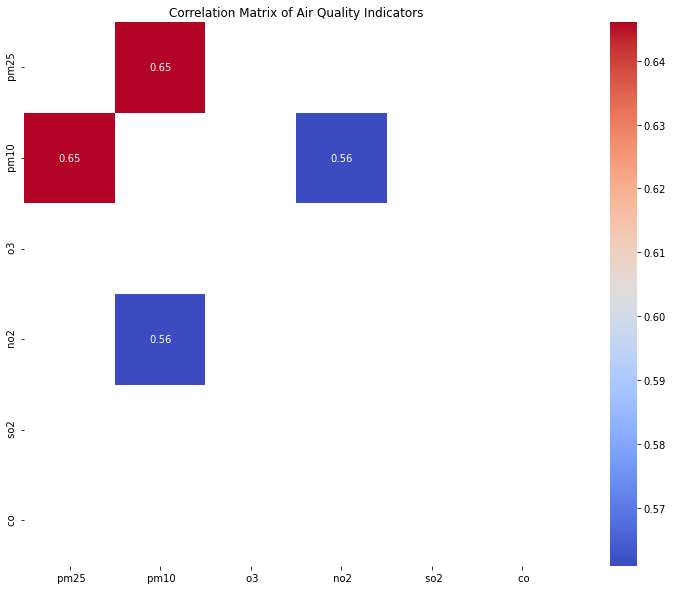

In [30]:
correlation_matrix = london_air_df.corr()
threshold = 0.5
high_correlation = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1)]
plt.figure(figsize=(15,10))
sns.heatmap(high_correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Air Quality Indicators')
plt.show()

In [31]:
london_air_df.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co'], dtype='object')

In [32]:
london_air_df['date'] = pd.to_datetime(london_air_df['date'])
monthly_df = london_air_df.set_index('date').resample('M').mean().reset_index()

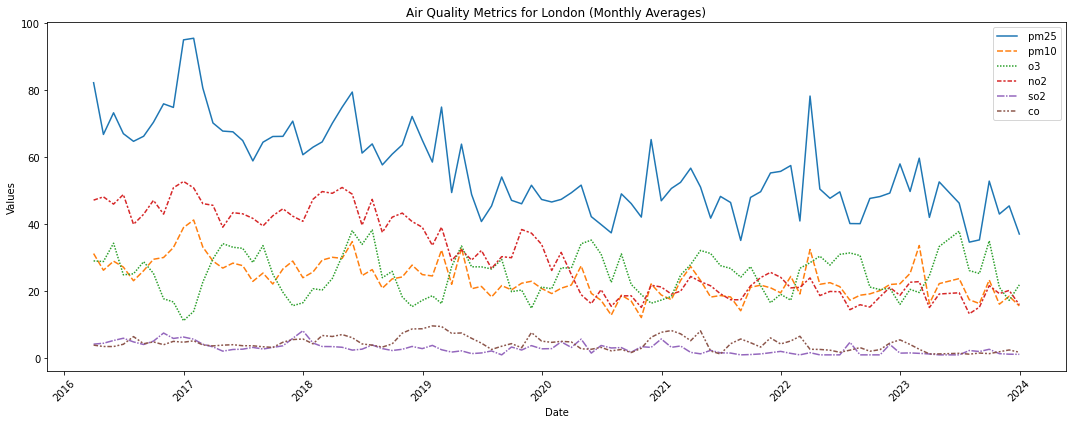

In [33]:
plt.figure(figsize=(15,6))
sns.lineplot(data=monthly_df.set_index("date"))
plt.title(f'Air Quality Metrics for London (Monthly Averages)')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
air_quality_data=london_air_df

## Vehicle type

In [35]:
vehicle_df = pd.read_csv('london_vehicle_data.csv')

In [36]:
vehicle_df.head()

,Unnamed: 0,type,Month,number,year,quarter
0,0,Diesel,2024 Q2,640800,2024,Q2
1,1,Petrol-Electric,2024 Q2,242800,2024,Q2
2,2,Other,2024 Q2,220900,2024,Q2
3,3,Petrol,2024 Q2,1894000,2024,Q2
4,4,Diesel,2024 Q1,647300,2024,Q1


In [37]:
vehicle_df.columns

Index(['Unnamed: 0', 'type', 'Month', 'number', 'year', 'quarter'], dtype='object')

In [38]:
vehicle_df.drop(columns='Unnamed: 0',inplace=True)

In [39]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type     472 non-null    object
 1   Month    472 non-null    object
 2   number   472 non-null    int64 
 3   year     472 non-null    int64 
 4   quarter  472 non-null    object
dtypes: int64(2), object(3)
memory usage: 18.6+ KB


In [40]:
vehicle_df.describe()

,number,year
count,4.720000e+02,472.000000
mean,3.822835e+05,2016.627119
std,6.698795e+05,4.278612
min,0.000000e+00,2009.000000
25%,1.590250e+03,2013.000000
50%,1.958450e+04,2017.000000
75%,3.423000e+05,2020.000000
max,2.227700e+06,2024.000000


In [41]:
vehicle_df=vehicle_df[(vehicle_df['year'] > 2015) & (vehicle_df['year'] < 2025)]

In [42]:
vehicle_df.tail()

,type,Month,number,year,quarter
367,Electric,2016 Q2,577,2016,Q2
368,Electric,2016 Q1,4243,2016,Q1
369,Diesel-Electric (Plug-In),2016 Q1,32,2016,Q1
370,Petrol-Electric (Plug-In),2016 Q1,2211,2016,Q1
371,Electric,2016 Q1,521,2016,Q1


In [43]:
#vehicle_df['year'] = pd.to_datetime(vehicle_df['year'])
#vehicle_df.year.min()

In [44]:
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272 entries, 0 to 371
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   type     272 non-null    object
 1   Month    272 non-null    object
 2   number   272 non-null    int64 
 3   year     272 non-null    int64 
 4   quarter  272 non-null    object
dtypes: int64(2), object(3)
memory usage: 12.8+ KB


In [45]:
# Check for missing values
print(vehicle_df.isnull().sum())

type       0
Month      0
number     0
year       0
quarter    0
dtype: int64


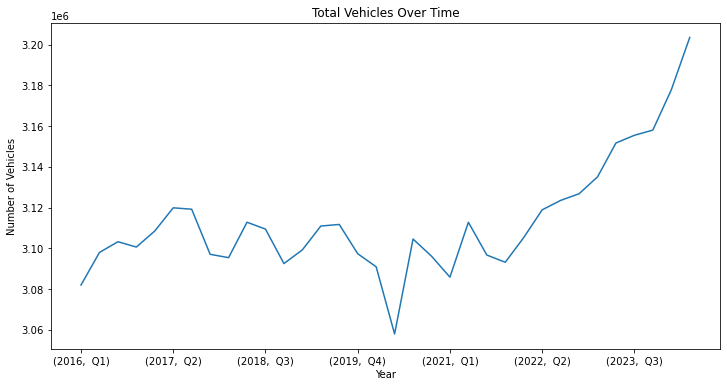

In [46]:
# Trend over time
monthly_trends = vehicle_df.set_index('year').groupby(['year','quarter'])['number'].sum()
monthly_trends.plot(figsize=(12, 6))
plt.title('Total Vehicles Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles')
plt.show()

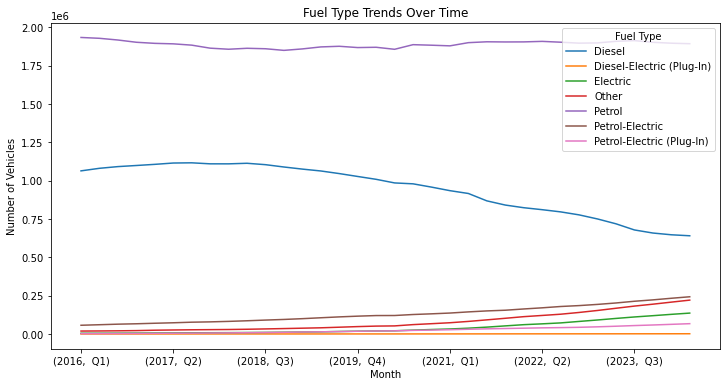

In [47]:
# Fuel type trends
fuel_trends = vehicle_df.groupby(['year','quarter', 'type'])['number'].sum().unstack()
fuel_trends.plot(figsize=(12, 6))
plt.title('Fuel Type Trends Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Vehicles')
plt.legend(title='Fuel Type')
plt.show()

In [48]:
vehicle_df.head()

,type,Month,number,year,quarter
0,Diesel,2024 Q2,640800,2024,Q2
1,Petrol-Electric,2024 Q2,242800,2024,Q2
2,Other,2024 Q2,220900,2024,Q2
3,Petrol,2024 Q2,1894000,2024,Q2
4,Diesel,2024 Q1,647300,2024,Q1


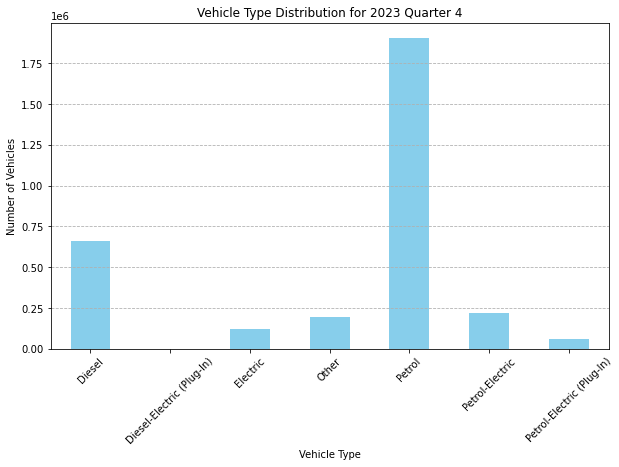

In [49]:
# Grouping and summing the number of vehicles by type for January 2020
specific_month = vehicle_df[vehicle_df['Month'] == '2023 Q4']
type_distribution = specific_month.groupby('type')['number'].sum()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
type_distribution.plot(kind='bar', color='skyblue')
plt.title('Vehicle Type Distribution for 2023 Quarter 4')
plt.xlabel('Vehicle Type')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

In [50]:
# Group by category and type, and calculate statistics
grouped_stats = (
    vehicle_df.groupby(['type'])['number']
    .agg(['sum', 'mean', 'count', 'min', 'max'])
    .reset_index()
)

grouped_stats

,type,sum,mean,count,min,max
0,Diesel,32215799,9.475235e+05,34,640800,1116800
1,Diesel-Electric (Plug-In),17814,5.239412e+02,34,32,1534
2,Electric,1382462,2.033032e+04,68,521,128463
3,Other,2698300,7.936176e+04,34,19100,220900
4,Petrol,64263200,1.890094e+06,34,1850500,1934700
5,Petrol-Electric,4425200,1.301529e+05,34,56900,242800
6,Petrol-Electric (Plug-In),850037,2.500109e+04,34,2211,67240


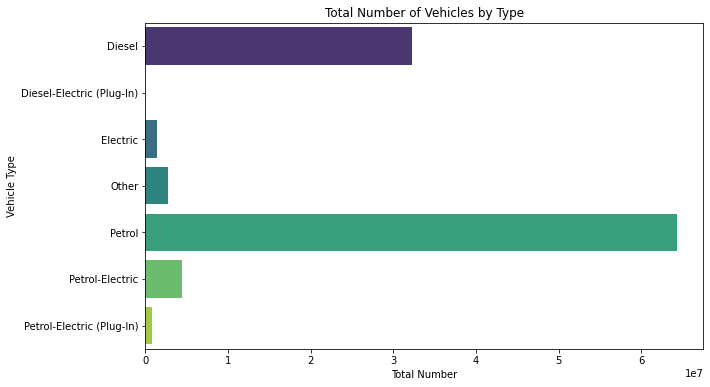

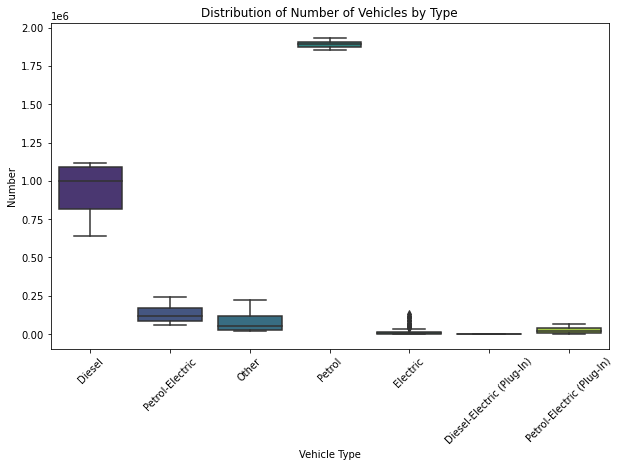

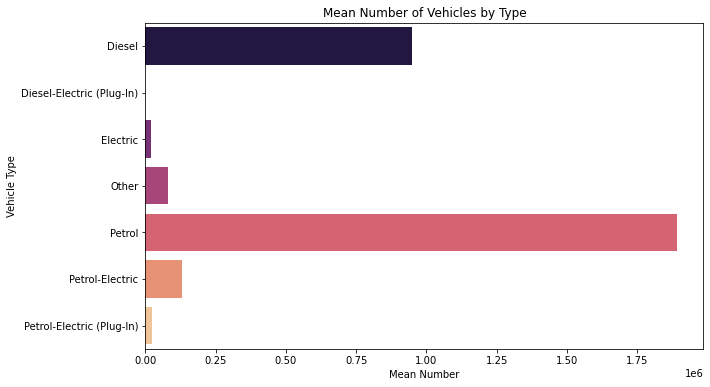

In [51]:
# Plot 1: Bar Plot for Total Numbers
plt.figure(figsize=(10, 6))
sns.barplot(x='sum', y='type', data=grouped_stats, palette='viridis')
plt.title('Total Number of Vehicles by Type')
plt.xlabel('Total Number')
plt.ylabel('Vehicle Type')
plt.show()

# Plot 2: Box Plot for Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='number', data=vehicle_df, palette='viridis')
plt.title('Distribution of Number of Vehicles by Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Number')
plt.xticks(rotation=45)
plt.show()

# Plot 3: Horizontal Bar Plot for Mean Values
plt.figure(figsize=(10, 6))
sns.barplot(x='mean', y='type', data=grouped_stats, palette='magma')
plt.title('Mean Number of Vehicles by Type')
plt.xlabel('Mean Number')
plt.ylabel('Vehicle Type')
plt.show()


### Categorinzing based on EV and Non_EV

In [52]:
vehicle_df.type.unique()

array(['Diesel', 'Petrol-Electric', 'Other', 'Petrol', 'Electric',
       'Diesel-Electric (Plug-In)', 'Petrol-Electric (Plug-In)'],
      dtype=object)

In [53]:
# Function to convert year and quarter to datetime
def quarter_to_date(row):
    month_mapping = {' Q1': 1, ' Q2': 4, ' Q3': 7, ' Q4': 10}
    return pd.Timestamp(year=row['year'], month=month_mapping[row['quarter']], day=1)

# Apply the function to create a new datetime column
vehicle_df['quarter_start'] = vehicle_df.apply(quarter_to_date, axis=1)
vehicle_df.head()

,type,Month,number,year,quarter,quarter_start
0,Diesel,2024 Q2,640800,2024,Q2,2024-04-01
1,Petrol-Electric,2024 Q2,242800,2024,Q2,2024-04-01
2,Other,2024 Q2,220900,2024,Q2,2024-04-01
3,Petrol,2024 Q2,1894000,2024,Q2,2024-04-01
4,Diesel,2024 Q1,647300,2024,Q1,2024-01-01


In [54]:
# Define EV and non-EV categories
def classify_fuel_type(fuel_type):
    if 'Electric' in fuel_type:
        return 'EV'
    else:
        return 'Non-EV'

vehicle_df['fuel_category'] = vehicle_df['type'].apply(classify_fuel_type)
# Group by year and fuel category, summing the counts
result = vehicle_df.groupby(['quarter_start', 'fuel_category'])['number'].mean().reset_index()

In [55]:
result.head()

,quarter_start,fuel_category,number
0,2016-01-01,EV,1.278140e+04
1,2016-01-01,Non-EV,1.006033e+06
2,2016-04-01,EV,1.361860e+04
3,2016-04-01,Non-EV,1.009967e+06
4,2016-07-01,EV,1.449160e+04


In [56]:
# Pivoting the DataFrame
ev_df = result.pivot(index='quarter_start', columns='fuel_category', values='number').reset_index()
ev_df['month'] = pd.to_datetime(ev_df['quarter_start'])
ev_df['year_month'] = ev_df['month'].dt.to_period('Q')

# Rename columns
ev_df.columns.name = None  # Remove the name of the columns
ev_df.rename(columns={'EV': 'EV', 'Non-EV': 'Non_EV'}, inplace=True)
ev_df.head()

,quarter_start,EV,Non_EV,month,year_month
0,2016-01-01,12781.4,1.006033e+06,2016-01-01,2016Q1
1,2016-04-01,13618.6,1.009967e+06,2016-04-01,2016Q2
2,2016-07-01,14491.6,1.010267e+06,2016-07-01,2016Q3
3,2016-10-01,15189.2,1.008233e+06,2016-10-01,2016Q4
4,2017-01-01,16166.0,1.009233e+06,2017-01-01,2017Q1


In [57]:
ev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   quarter_start  34 non-null     datetime64[ns]
 1   EV             34 non-null     float64       
 2   Non_EV         34 non-null     float64       
 3   month          34 non-null     datetime64[ns]
 4   year_month     34 non-null     period[Q-DEC] 
dtypes: datetime64[ns](2), float64(2), period[Q-DEC](1)
memory usage: 1.5 KB


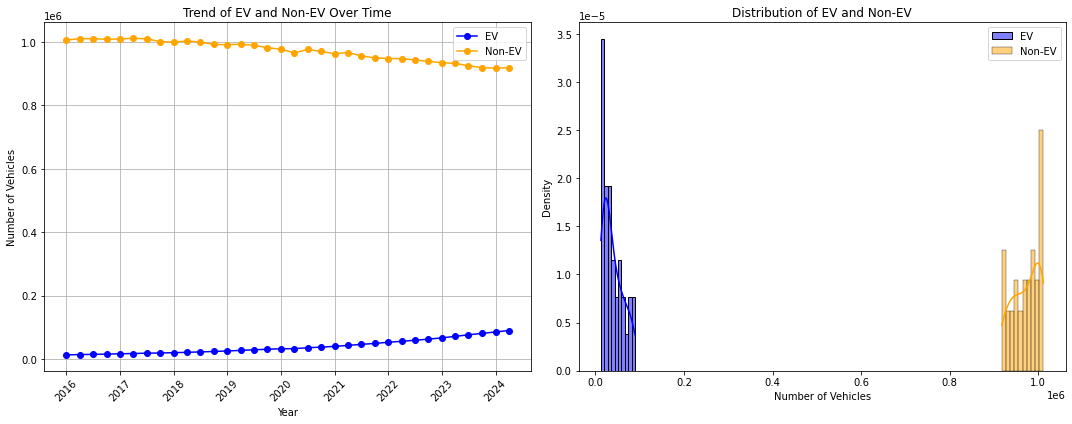

In [58]:
# 3. Visualizations
plt.figure(figsize=(15, 6))

# Trend Over Time
plt.subplot(1, 2, 1)
plt.plot(ev_df['quarter_start'], ev_df['EV'], label='EV', color='blue', marker='o')
plt.plot(ev_df['quarter_start'], ev_df['Non_EV'], label='Non-EV', color='orange', marker='o')
plt.title('Trend of EV and Non-EV Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.xticks(rotation=45)
plt.grid()

# Distribution
plt.subplot(1, 2, 2)
sns.histplot(ev_df['EV'], bins=10, color='blue', label='EV', kde=True, stat='density')
sns.histplot(ev_df['Non_EV'], bins=10, color='orange', label='Non-EV', kde=True, stat='density', alpha=0.5)
plt.title('Distribution of EV and Non-EV')
plt.xlabel('Number of Vehicles')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

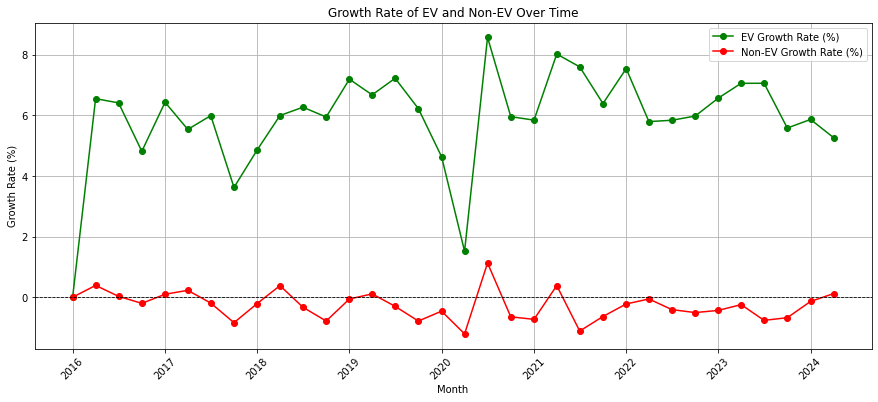

In [59]:
# 4. Growth Analysis
ev_df['EV_growth'] = ev_df['EV'].pct_change().fillna(0) * 100
ev_df['Non_EV_growth'] = ev_df['Non_EV'].pct_change().fillna(0) * 100

plt.figure(figsize=(15, 6))
plt.plot(ev_df['quarter_start'], ev_df['EV_growth'], label='EV Growth Rate (%)', color='green', marker='o')
plt.plot(ev_df['quarter_start'], ev_df['Non_EV_growth'], label='Non-EV Growth Rate (%)', color='red', marker='o')
plt.title('Growth Rate of EV and Non-EV Over Time')
plt.xlabel('Month')
plt.ylabel('Growth Rate (%)')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.show()

In [60]:
ev_df.head()

,quarter_start,EV,Non_EV,month,year_month,EV_growth,Non_EV_growth
0,2016-01-01,12781.4,1.006033e+06,2016-01-01,2016Q1,0.000000,0.000000
1,2016-04-01,13618.6,1.009967e+06,2016-04-01,2016Q2,6.550143,0.390974
2,2016-07-01,14491.6,1.010267e+06,2016-07-01,2016Q3,6.410351,0.029704
3,2016-10-01,15189.2,1.008233e+06,2016-10-01,2016Q4,4.813823,-0.201267
4,2017-01-01,16166.0,1.009233e+06,2017-01-01,2017Q1,6.430885,0.099183


### London Road Traffic Condition

In [61]:
road_traffic_condition = pd.read_csv('region_traffic_by_vehicle_type.csv')
road_traffic_condition.head()

,year,region_id,region_name,region_ons_code,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,LGVs,all_HGVs,all_motor_vehicles
0,1993,1,South West,E12000009,48751.55,30292.81,228000000.0,289900000.0,1.967430e+10,245000000.0,2.351700e+09,1.295600e+09,2.385660e+10
1,1993,2,East Midlands,E12000004,30681.75,19064.76,199700000.0,172800000.0,1.620020e+10,190100000.0,2.082200e+09,1.647100e+09,2.029240e+10
2,1993,3,Scotland,S92000003,58532.65,36370.50,147300000.0,126400000.0,1.767760e+10,334300000.0,2.230000e+09,1.339900e+09,2.170930e+10
3,1993,4,Wales,W92000004,32543.50,20221.59,81700000.0,104600000.0,1.127880e+10,156300000.0,1.452700e+09,7.352000e+08,1.372760e+10
4,1993,5,North West,E12000002,35952.60,22339.91,251400000.0,199200000.0,2.370000e+10,339800000.0,2.801800e+09,1.834400e+09,2.890520e+10


In [62]:
road_traffic_condition=road_traffic_condition[road_traffic_condition.region_name=="London"]

In [63]:
road_traffic_condition=road_traffic_condition[(road_traffic_condition['year'] > 2015) & (road_traffic_condition['year'] < 2025)]

In [64]:
road_traffic_condition

,year,region_id,region_name,region_ons_code,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,LGVs,all_HGVs,all_motor_vehicles
258,2016,6,London,E12000007,14833.53,9217.13,506300000.0,473600000.0,1.542140e+10,325400000.0,3.224400e+09,638200000.0,2.010000e+10
269,2017,6,London,E12000007,14842.02,9222.40,500500000.0,468800000.0,1.539780e+10,314800000.0,3.268100e+09,605900000.0,2.005540e+10
280,2018,6,London,E12000007,14807.73,9201.10,518000000.0,463400000.0,1.536030e+10,311400000.0,3.259900e+09,597900000.0,1.999290e+10
291,2019,6,London,E12000007,14814.85,9205.52,467800000.0,493200000.0,1.562890e+10,280300000.0,3.264400e+09,597500000.0,2.026440e+10
302,2020,6,London,E12000007,14806.32,9200.22,697700000.0,463500000.0,1.245350e+10,226100000.0,2.877500e+09,593000000.0,1.661360e+10
313,2021,6,London,E12000007,14808.32,9201.46,647200000.0,607600000.0,1.398340e+10,239000000.0,2.987800e+09,635500000.0,1.845330e+10
324,2022,6,London,E12000007,14812.69,9204.18,605800000.0,701600000.0,1.445950e+10,247800000.0,3.031900e+09,648600000.0,1.908930e+10
335,2023,6,London,E12000007,14817.39,9207.10,627800000.0,742100000.0,1.460000e+10,253000000.0,2.989500e+09,621000000.0,1.919670e+10


In [65]:
road_traffic_condition=road_traffic_condition.reset_index().drop(columns='index')
road_traffic_condition

,year,region_id,region_name,region_ons_code,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,LGVs,all_HGVs,all_motor_vehicles
0,2016,6,London,E12000007,14833.53,9217.13,506300000.0,473600000.0,1.542140e+10,325400000.0,3.224400e+09,638200000.0,2.010000e+10
1,2017,6,London,E12000007,14842.02,9222.40,500500000.0,468800000.0,1.539780e+10,314800000.0,3.268100e+09,605900000.0,2.005540e+10
2,2018,6,London,E12000007,14807.73,9201.10,518000000.0,463400000.0,1.536030e+10,311400000.0,3.259900e+09,597900000.0,1.999290e+10
3,2019,6,London,E12000007,14814.85,9205.52,467800000.0,493200000.0,1.562890e+10,280300000.0,3.264400e+09,597500000.0,2.026440e+10
4,2020,6,London,E12000007,14806.32,9200.22,697700000.0,463500000.0,1.245350e+10,226100000.0,2.877500e+09,593000000.0,1.661360e+10
5,2021,6,London,E12000007,14808.32,9201.46,647200000.0,607600000.0,1.398340e+10,239000000.0,2.987800e+09,635500000.0,1.845330e+10
6,2022,6,London,E12000007,14812.69,9204.18,605800000.0,701600000.0,1.445950e+10,247800000.0,3.031900e+09,648600000.0,1.908930e+10
7,2023,6,London,E12000007,14817.39,9207.10,627800000.0,742100000.0,1.460000e+10,253000000.0,2.989500e+09,621000000.0,1.919670e+10


### 1. Data preprocessing

In [66]:
ev_df.columns

Index(['quarter_start', 'EV', 'Non_EV', 'month', 'year_month', 'EV_growth',
       'Non_EV_growth'],
      dtype='object')

In [67]:
london_air_df.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co'], dtype='object')

In [68]:
# Convert 'date' to datetime and extract year-month from air quality
london_air_df['date'] = pd.to_datetime(london_air_df['date'])
london_air_df['year_month'] = london_air_df['date'].dt.to_period('Q')

# Average air quality measurements by month
average_air_quality = london_air_df.groupby('year_month').mean().reset_index()
average_air_quality.head()

,year_month,pm25,pm10,o3,no2,so2,co
0,2016Q1,82.238095,31.238095,29.047619,47.190476,4.200000,3.904762
1,2016Q2,69.076923,27.494505,29.417582,47.659341,5.241758,3.714286
2,2016Q3,67.108696,26.228261,26.456522,43.315217,4.684783,5.217391
3,2016Q4,82.021739,34.043478,15.228261,48.858696,6.586957,4.608696
4,2017Q1,82.177778,34.522222,22.100000,47.588889,4.422222,4.288889


In [69]:
ev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   quarter_start  34 non-null     datetime64[ns]
 1   EV             34 non-null     float64       
 2   Non_EV         34 non-null     float64       
 3   month          34 non-null     datetime64[ns]
 4   year_month     34 non-null     period[Q-DEC] 
 5   EV_growth      34 non-null     float64       
 6   Non_EV_growth  34 non-null     float64       
dtypes: datetime64[ns](2), float64(4), period[Q-DEC](1)
memory usage: 2.0 KB


In [70]:
# Convert 'month' to datetime and extract year-month from vehicle sales
ev_df['year'] = pd.to_datetime(ev_df['month'])
ev_df['year_month'] = ev_df['month'].dt.strftime('%Y-%q')

# Calculate total EV and Non-EV sales
sales_data = ev_df.drop(columns=['EV_growth','Non_EV_growth']).groupby('year_month').mean().reset_index()
sales_data.head()

,year_month,EV,Non_EV
0,2016-01-01 00:00:00,12781.4,1.006033e+06
1,2016-04-01 00:00:00,13618.6,1.009967e+06
2,2016-07-01 00:00:00,14491.6,1.010267e+06
3,2016-10-01 00:00:00,15189.2,1.008233e+06
4,2017-01-01 00:00:00,16166.0,1.009233e+06


In [71]:
sales_data['year_month'] = pd.to_datetime(sales_data['year_month'])
sales_data['year_month']=sales_data['year_month'].dt.to_period('Q')

In [72]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype        
---  ------      --------------  -----        
 0   year_month  34 non-null     period[Q-DEC]
 1   EV          34 non-null     float64      
 2   Non_EV      34 non-null     float64      
dtypes: float64(2), period[Q-DEC](1)
memory usage: 944.0 bytes


In [73]:
# Merge sales and air quality data on year_month
merged_data = pd.merge(sales_data, average_air_quality, on='year_month')
merged_data.head()

,year_month,EV,Non_EV,pm25,pm10,o3,no2,so2,co
0,2016Q1,12781.4,1.006033e+06,82.238095,31.238095,29.047619,47.190476,4.200000,3.904762
1,2016Q2,13618.6,1.009967e+06,69.076923,27.494505,29.417582,47.659341,5.241758,3.714286
2,2016Q3,14491.6,1.010267e+06,67.108696,26.228261,26.456522,43.315217,4.684783,5.217391
3,2016Q4,15189.2,1.008233e+06,82.021739,34.043478,15.228261,48.858696,6.586957,4.608696
4,2017Q1,16166.0,1.009233e+06,82.177778,34.522222,22.100000,47.588889,4.422222,4.288889


In [74]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype        
---  ------      --------------  -----        
 0   year_month  32 non-null     period[Q-DEC]
 1   EV          32 non-null     float64      
 2   Non_EV      32 non-null     float64      
 3    pm25       32 non-null     float64      
 4    pm10       32 non-null     float64      
 5    o3         32 non-null     float64      
 6    no2        32 non-null     float64      
 7    so2        32 non-null     float64      
 8    co         32 non-null     float64      
dtypes: float64(8), period[Q-DEC](1)
memory usage: 2.5 KB


In [75]:
# Convert 'year_month' to string
merged_data['year_month'] = merged_data['year_month'].astype(str)

### 2. EDA

In [76]:
merged_data.columns

Index(['year_month', 'EV', 'Non_EV', ' pm25', ' pm10', ' o3', ' no2', ' so2',
       ' co'],
      dtype='object')

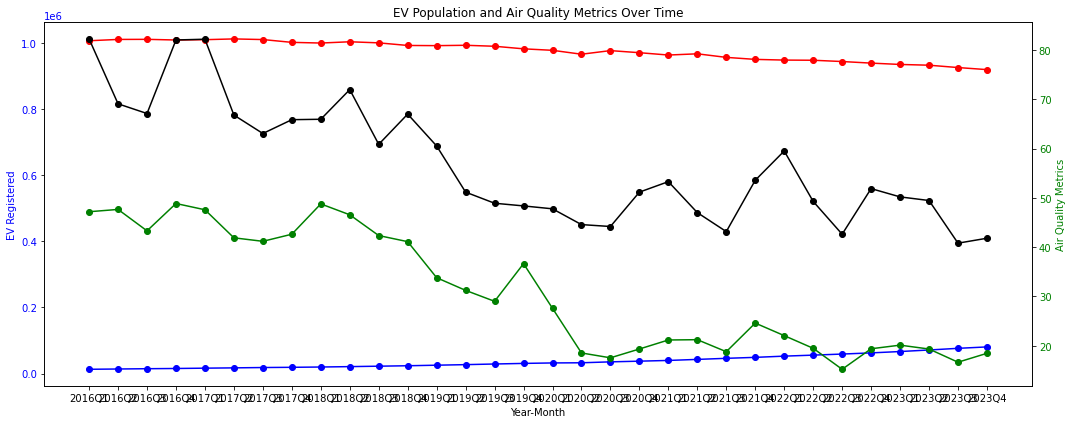

In [77]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# EV trend
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('EV Registered', color='blue')
ax1.plot(merged_data['year_month'].astype(str), merged_data['EV'], color='blue', marker='o',label='EV Registered')
ax1.plot(merged_data['year_month'].astype(str), merged_data['Non_EV'], color='red',marker='o', label='Non EV Registered')
ax1.tick_params(axis='y', labelcolor='blue')

# Air quality trend
ax2 = ax1.twinx()
ax2.set_ylabel('Air Quality Metrics', color='green')
ax2.plot(merged_data['year_month'].astype(str), merged_data[' no2'], color='green',marker='o', label='No2')
ax2.plot(merged_data['year_month'].astype(str), merged_data[' pm25'], color='black',marker='o', label='PM2.5')
ax2.tick_params(axis='y', labelcolor='green')

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.title('EV Population and Air Quality Metrics Over Time')
fig.tight_layout()

plt.show()

In [78]:
vehicle_population=vehicle_df

### A. Air Quality Improvement Hypothesis:

***Null Hypothesis (H0):*** There is no significant relationship between the increase in EV adoption and changes in air quality.

***Alternative Hypothesis (H1):*** There is a significant relationship between the increase in EV adoption and improvements in air quality (measured by reductions in (CO, SO2, O3, PM2.5, PM10 and PSI values)).


In [79]:
air_quality_data.head()

,date,pm25,pm10,o3,no2,so2,co,year_month
280,2023-10-01,46.0,19.0,17.0,21.0,1.357143,2.0,2023Q4
281,2023-10-02,48.0,14.0,23.0,19.0,1.357143,2.0,2023Q4
282,2023-10-03,23.0,12.0,25.0,23.0,1.357143,1.0,2023Q4
283,2023-10-04,22.0,13.0,29.0,25.0,1.357143,1.0,2023Q4
284,2023-10-05,30.0,15.0,27.0,20.0,1.357143,2.0,2023Q4


In [80]:
air_quality_data['year_month'] = air_quality_data['date'].dt.to_period('Q')

In [81]:
vehicle_population['month'] = pd.to_datetime(vehicle_population['quarter_start'])
vehicle_population['year_month'] = vehicle_population['month'].dt.to_period('Q')

In [82]:
# Step 2: Filter the vehicle population for EV and non-EV cars only
ev_population = vehicle_population[vehicle_population['type'] == 'Electric']
non_ev_population = vehicle_population[vehicle_population['type'] != 'Electric']

# Step 3: Aggregate EV and non-EV vehicle population by year-month
ev_grouped = ev_population.groupby('year_month')['number'].mean().reset_index(name='EV')
non_ev_grouped = non_ev_population.groupby('year_month')['number'].mean().reset_index(name='Non_EV')

In [83]:
# Step 4: Merge the air quality data with EV and Non-EV population
merged_data = pd.merge(air_quality_data, ev_grouped, on='year_month', how='left')
merged_data = pd.merge(merged_data, non_ev_grouped, on='year_month', how='left')

# Preview the merged data
merged_data.head()

,date,pm25,pm10,o3,no2,so2,co,year_month,EV,Non_EV
0,2023-10-01,46.0,19.0,17.0,21.0,1.357143,2.0,2023Q4,59686.5,506445.166667
1,2023-10-02,48.0,14.0,23.0,19.0,1.357143,2.0,2023Q4,59686.5,506445.166667
2,2023-10-03,23.0,12.0,25.0,23.0,1.357143,1.0,2023Q4,59686.5,506445.166667
3,2023-10-04,22.0,13.0,29.0,25.0,1.357143,1.0,2023Q4,59686.5,506445.166667
4,2023-10-05,30.0,15.0,27.0,20.0,1.357143,2.0,2023Q4,59686.5,506445.166667


In [84]:
scaler = MinMaxScaler()

# Normalize the air quality metrics (CO, PM2.5, PM10, PSI)
cols_to_normalize = ['EV']
merged_data[cols_to_normalize] = scaler.fit_transform(merged_data[cols_to_normalize])

# Preview the normalized data
merged_data.head()

,date,pm25,pm10,o3,no2,so2,co,year_month,EV,Non_EV
0,2023-10-01,46.0,19.0,17.0,21.0,1.357143,2.0,2023Q4,1.0,506445.166667
1,2023-10-02,48.0,14.0,23.0,19.0,1.357143,2.0,2023Q4,1.0,506445.166667
2,2023-10-03,23.0,12.0,25.0,23.0,1.357143,1.0,2023Q4,1.0,506445.166667
3,2023-10-04,22.0,13.0,29.0,25.0,1.357143,1.0,2023Q4,1.0,506445.166667
4,2023-10-05,30.0,15.0,27.0,20.0,1.357143,2.0,2023Q4,1.0,506445.166667


In [85]:
merged_data.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'year_month',
       'EV', 'Non_EV'],
      dtype='object')

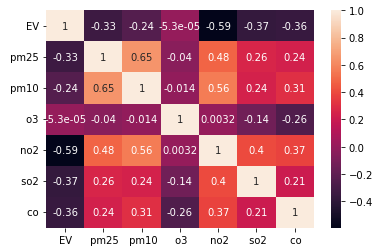

In [86]:
# Calculate correlation between EV adoption and air quality metrics
correlation_matrix = merged_data[['EV', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']].corr()
sns.heatmap(correlation_matrix,annot=True)
plt.show()

### Hypothesis Test Method 1:
***Spearman Correlation***

In [87]:
merged_data.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'year_month',
       'EV', 'Non_EV'],
      dtype='object')

In [122]:
from scipy.stats import spearmanr

# Perform Spearman correlation test for each air quality metric against EV numbers
co_spearman_corr, co_spearman_pval = spearmanr(merged_data['EV'], merged_data[' co'])
o3_spearman_corr, o3_spearman_pval = spearmanr(merged_data['EV'], merged_data[' o3'])
so2_spearman_corr, so2_spearman_pval = spearmanr(merged_data['EV'], merged_data[' so2'])
pm25_spearman_corr, pm25_spearman_pval = spearmanr(merged_data['EV'], merged_data[' pm25'])
pm10_spearman_corr, pm10_spearman_pval = spearmanr(merged_data['EV'], merged_data[' pm10'])
no2_spearman_corr, no2_spearman_pval = spearmanr(merged_data['EV'], merged_data[' no2'])

# Print Spearman correlation results
print(f"CO vs EV: Spearman Corr = {co_spearman_corr}, p-value = {co_spearman_pval}")
print(f"O3 vs EV: Spearman Corr = {o3_spearman_corr}, p-value = {o3_spearman_pval}")
print(f"So2 vs EV: Spearman Corr = {so2_spearman_corr}, p-value = {so2_spearman_pval}")
print(f"PM2.5 vs EV: Spearman Corr = {pm25_spearman_corr}, p-value = {pm25_spearman_pval}")
print(f"PM10 vs EV: Spearman Corr = {pm10_spearman_corr}, p-value = {pm10_spearman_pval}")
print(f"NO2 vs EV: Spearman Corr = {no2_spearman_corr}, p-value = {no2_spearman_pval}")


CO vs EV: Spearman Corr = -0.3526311049980005, p-value = 5.610966012277835e-83
O3 vs EV: Spearman Corr = -0.011627036341946631, p-value = 0.5380529672903598
So2 vs EV: Spearman Corr = -0.5491767935904823, p-value = 6.284605838179024e-221
PM2.5 vs EV: Spearman Corr = -0.5004162017077382, p-value = 8.190658345102772e-178
PM10 vs EV: Spearman Corr = -0.38125022525808877, p-value = 8.465844886519075e-98
NO2 vs EV: Spearman Corr = -0.7498009689246219, p-value = 0.0


In [123]:
def hypothesis_test(corr, p_val, alpha=0.05):
    if p_val < alpha:
        return f"Reject the null hypothesis. Significant relationship detected (Correlation: {corr}, p-value: {p_val})."
    else:
        return f"Fail to reject the null hypothesis. No significant relationship detected (Correlation: {corr}, p-value: {p_val})."

# Hypothesis test results
co_result = hypothesis_test(co_corr, co_pval)
o3_result = hypothesis_test(o3_corr, o3_pval)
so2_result = hypothesis_test(so2_corr, so2_pval)
pm25_result = hypothesis_test(pm25_corr, pm25_pval)
pm10_result = hypothesis_test(pm10_corr, pm10_pval)
no2_result = hypothesis_test(no2_corr, no2_pval)

print(f"CO vs EV: {co_result}")
print(f"O3 vs EV: {o3_result}")
print(f"So2 vs EV: {so2_result}")
print(f"PM2.5 vs EV: {pm25_result}")
print(f"PM10 vs EV: {pm10_result}")
print(f"PSI vs EV: {no2_result}")

CO vs EV: Reject the null hypothesis. Significant relationship detected (Correlation: -0.35859890274349954, p-value: 6.055882443707755e-86).
O3 vs EV: Fail to reject the null hypothesis. No significant relationship detected (Correlation: -5.340370040477806e-05, p-value: 0.9977434832584894).
So2 vs EV: Reject the null hypothesis. Significant relationship detected (Correlation: -0.3721846116118606, p-value: 6.118322521917755e-93).
PM2.5 vs EV: Reject the null hypothesis. Significant relationship detected (Correlation: -0.33306269925618426, p-value: 1.0872619442667136e-73).
PM10 vs EV: Reject the null hypothesis. Significant relationship detected (Correlation: -0.24359257141726792, p-value: 3.387683747332385e-39).
PSI vs EV: Reject the null hypothesis. Significant relationship detected (Correlation: -0.594515522233049, p-value: 5.945327613717555e-268).


### The results for the Pearson correlation between EV adoption and air quality measures (CO, PM2.5, PM10, NO2). 

#### Pearson Correlation Results:

1. CO vs EV: 
    
2. O3 vs EV: 

3. So2 vs EV: 
   
4. PM2.5 vs EV: 
    
5. PM10 vs EV: 
    
6. No2 vs EV: 
    

### Hypotheis Test Method 2:

***Linear Regression:*** To quantify the impact of EV adoption on air quality metrics, we use linear regression, with EV adoption as the independent variable and air quality measures as dependent variables. This approach allows us to model how much each air quality metric changes with an increase in EV adoption. The p-values for the regression coefficients confirm whether the relationship is statistically significant.

In [113]:
merged_data.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'year_month',
       'EV', 'Non_EV'],
      dtype='object')

In [91]:
import statsmodels.api as sm

# Step 1: Define the independent variable (EV) and dependent variables (air quality metrics)
X = merged_data['EV']
X = sm.add_constant(X)  # Adding a constant for intercept

# Step 2: Linear regression for each air quality metric
for metric in [' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']:
    y = merged_data[metric]
    model = sm.OLS(y, X).fit()
    print(f"Regression results for {metric}:")
    print(model.summary())
    print("\n")

Regression results for  pm25:
                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     350.0
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           1.09e-73
Time:                        20:53:47   Log-Likelihood:                -12448.
No. Observations:                2807   AIC:                         2.490e+04
Df Residuals:                    2805   BIC:                         2.491e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.8811 

C:\Users\dhind\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [92]:
import numpy as np
import statsmodels.api as sm

# Define significance level
alpha = 0.05

# Results from regression analysis
p_values = {'CO': 0.705,'SO2': 1.34e-66,'O3': 0.0371,'PM2.5': 3.21e-06,'PM10': 1.48e-05,'PSI': 0.00185}

# Check if we reject or fail to reject the null hypothesis
for pollutant, p_value in p_values.items():
    if p_value < alpha:
        print(f"Reject null hypothesis for {pollutant} (p-value = {p_value})")
    else:
        print(f"Fail to reject null hypothesis for {pollutant} (p-value = {p_value})")


Fail to reject null hypothesis for CO (p-value = 0.705)
Reject null hypothesis for SO2 (p-value = 1.34e-66)
Reject null hypothesis for O3 (p-value = 0.0371)
Reject null hypothesis for PM2.5 (p-value = 3.21e-06)
Reject null hypothesis for PM10 (p-value = 1.48e-05)
Reject null hypothesis for PSI (p-value = 0.00185)


#### Linear Regression Results:
1. CO vs EV:

2. So2 vs EV:

3. O3 vs EV:

4. PM2.5 vs EV:

5. PM10 vs EV:

6. No2 vs EV:


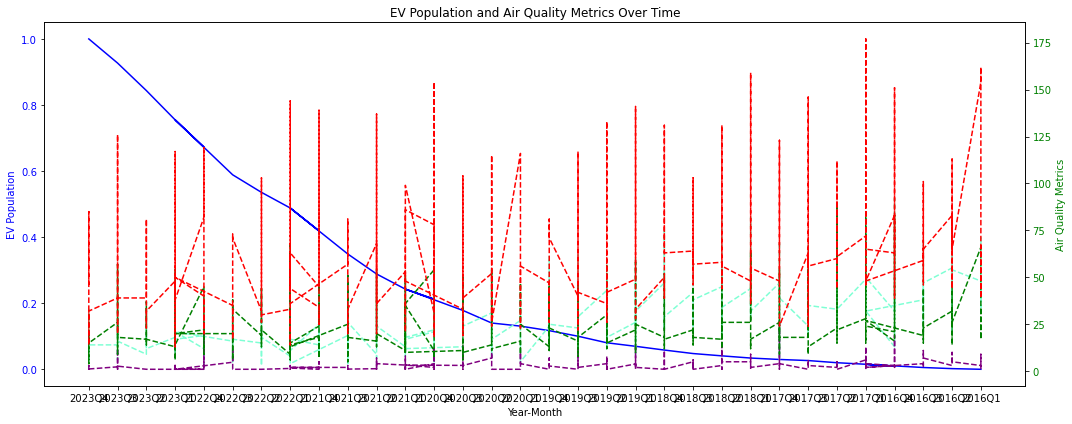

In [93]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# EV trend
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('EV Population', color='blue')
ax1.plot(merged_data['year_month'].astype(str), merged_data['EV'], color='blue', label='EV Population')
ax1.tick_params(axis='y', labelcolor='blue')

# Air quality trend
ax2 = ax1.twinx()
ax2.set_ylabel('Air Quality Metrics', color='green')
ax2.plot(merged_data['year_month'].astype(str), merged_data[' no2'], color='aquamarine', label='So2 National', linestyle='--')
ax2.plot(merged_data['year_month'].astype(str), merged_data[' so2'], color='purple', label='Psi 24hr National', linestyle='--')
ax2.plot(merged_data['year_month'].astype(str), merged_data[' pm10'], color='green', label='PM10 National', linestyle='--')
ax2.plot(merged_data['year_month'].astype(str), merged_data[' pm25'], color='red', label='PM2.5 National', linestyle='--')
ax2.tick_params(axis='y', labelcolor='green')

# Rotate and format the x-axis labels
plt.xticks(rotation=45)
plt.title('EV Population and Air Quality Metrics Over Time')
fig.tight_layout()

plt.show()

### Hypothesis Test Result


### B. Fuel Type and Air Quality Hypothesis:

***Null Hypothesis (H0):*** The type of fuel used (petrol, diesel, electric) in vehicles has no significant impact on air quality.

***Alternative Hypothesis (H1):*** The type of fuel used in vehicles significantly impacts air quality.

In [94]:
air_quality_data.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'year_month'], dtype='object')

In [95]:
vehicle_df.type.unique()

array(['Diesel', 'Petrol-Electric', 'Other', 'Petrol', 'Electric',
       'Diesel-Electric (Plug-In)', 'Petrol-Electric (Plug-In)'],
      dtype=object)

In [105]:
def categorize_fuel_type(fuel_type):
    if fuel_type in ['Petrol', 'Petrol-Electric', 'Petrol-Electric (Plug-In)']:
        return 'Petrol-based'
    elif fuel_type in ['Diesel', 'Diesel-Electric', 'Diesel-Electric (Plug-In)']:
        return 'Diesel-based'
    elif fuel_type == 'Other':
        return 'Other'
    elif fuel_type == 'Electric':
        return 'Electric'

# Apply the function to categorize fuel types
vehicle_df['fuel_category'] = vehicle_df['type'].apply(categorize_fuel_type)
vehicle_df.head()

,type,Month,number,year,quarter,quarter_start,fuel_category,month,year_month
0,Diesel,2024 Q2,640800,2024,Q2,2024-04-01,Diesel-based,2024-04-01,2024Q2
1,Petrol-Electric,2024 Q2,242800,2024,Q2,2024-04-01,Petrol-based,2024-04-01,2024Q2
2,Other,2024 Q2,220900,2024,Q2,2024-04-01,Other,2024-04-01,2024Q2
3,Petrol,2024 Q2,1894000,2024,Q2,2024-04-01,Petrol-based,2024-04-01,2024Q2
4,Diesel,2024 Q1,647300,2024,Q1,2024-01-01,Diesel-based,2024-01-01,2024Q1


In [106]:
air_quality_data.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'year_month'], dtype='object')

In [107]:
# Merge vehicle data with air quality data
combined_df = pd.merge(air_quality_data[['year_month',' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']], vehicle_df, on='year_month')
combined_df.head()

,year_month,pm25,pm10,o3,no2,so2,co,type,Month,number,year,quarter,quarter_start,fuel_category,month
0,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Diesel,2023 Q4,658700,2023,Q4,2023-10-01,Diesel-based,2023-10-01
1,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Petrol-Electric,2023 Q4,222500,2023,Q4,2023-10-01,Petrol-based,2023-10-01
2,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Other,2023 Q4,194400,2023,Q4,2023-10-01,Other,2023-10-01
3,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Petrol,2023 Q4,1903100,2023,Q4,2023-10-01,Petrol-based,2023-10-01
4,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Electric,2023 Q4,112051,2023,Q4,2023-10-01,Electric,2023-10-01


In [108]:
# Calculate weighted averages for each fuel category based on the number of vehicles
def weighted_mean(group, metric):
    return (group[metric] * group['number']).sum() / group['number'].sum()

# Group by fuel category and calculate weighted means for air quality metrics
weighted_grouped_df = combined_df.groupby('fuel_category').apply(
    lambda group: pd.Series({
        ' co': weighted_mean(group, ' co'),
        ' o3': weighted_mean(group, ' o3'),
        ' pm25': weighted_mean(group, ' pm25'),
        ' pm10': weighted_mean(group, ' pm10'),
        ' so2': weighted_mean(group,' so2'),
        ' no2': weighted_mean(group, ' no2')
    })
).reset_index()

In [109]:
weighted_grouped_df

,fuel_category,co,o3,pm25,pm10,so2,no2
0,Diesel-based,4.518653,24.998487,57.615607,23.979793,3.042927,32.101199
1,Electric,3.413676,24.996279,49.470628,21.248988,2.054009,22.126496
2,Other,3.675177,24.992656,50.919763,21.707135,2.242824,23.954560
3,Petrol-based,4.336892,25.003913,56.139648,23.470066,2.873437,30.275319


#### Weighted ANOVA Testing Methodology:
Accounting for Different Group Sizes (Vehicle Numbers):
* In the context of analyzing the impact of fuel type on air quality, the number of vehicles running on each fuel type varies significantly (e.g., far more petrol vehicles than electric vehicles). A standard ANOVA treats each observation equally, but this would ignore the fact that some fuel types have far more vehicles contributing to pollution.
* Weighted ANOVA addresses this by adjusting the analysis to reflect the true contribution of each fuel type to air quality based on how many vehicles of that type are on the road. Thus, categories with more vehicles are given more weight in the analysis, aligning the results with reality.

In [110]:
# Prepare the data for ANOVA
fuel_types = ['Petrol-based', 'Diesel-based', 'Electric','Other']
air_quality_metrics = [' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']

# Perform ANOVA for each air quality metric
for metric in air_quality_metrics:
    data = [combined_df[combined_df['fuel_category'] == fuel][metric] for fuel in fuel_types]
    f_stat, p_value = stats.f_oneway(*data)
    print(f'ANOVA for {metric}: F-statistic = {f_stat}, p-value = {p_value}')

    # Hypothesis test interpretation
    if p_value < 0.05:
        print(f'Reject the null hypothesis for {metric}. There is a significant impact of fuel type on {metric}.')
    else:
        print(f'Fail to reject the null hypothesis for {metric}. There is no significant impact of fuel type on {metric}.')


ANOVA for  pm25: F-statistic = 4.2775297850313446e-29, p-value = 1.0
Fail to reject the null hypothesis for  pm25. There is no significant impact of fuel type on  pm25.
ANOVA for  pm10: F-statistic = 3.382298991151228e-29, p-value = 1.0
Fail to reject the null hypothesis for  pm10. There is no significant impact of fuel type on  pm10.
ANOVA for  o3: F-statistic = 0.0, p-value = 1.0
Fail to reject the null hypothesis for  o3. There is no significant impact of fuel type on  o3.
ANOVA for  no2: F-statistic = 6.2562961130252736e-30, p-value = 1.0
Fail to reject the null hypothesis for  no2. There is no significant impact of fuel type on  no2.
ANOVA for  so2: F-statistic = 1.8495496705777607e-29, p-value = 1.0
Fail to reject the null hypothesis for  so2. There is no significant impact of fuel type on  so2.
ANOVA for  co: F-statistic = 4.4977904751489565e-29, p-value = 1.0
Fail to reject the null hypothesis for  co. There is no significant impact of fuel type on  co.


### The results of the ANOVA tests indicate the following:



In [112]:
combined_df.head()

,year_month,pm25,pm10,o3,no2,so2,co,type,Month,number,year,quarter,quarter_start,fuel_category,month
0,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Diesel,2023 Q4,658700,2023,Q4,2023-10-01,Diesel-based,2023-10-01
1,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Petrol-Electric,2023 Q4,222500,2023,Q4,2023-10-01,Petrol-based,2023-10-01
2,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Other,2023 Q4,194400,2023,Q4,2023-10-01,Other,2023-10-01
3,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Petrol,2023 Q4,1903100,2023,Q4,2023-10-01,Petrol-based,2023-10-01
4,2023Q4,46.0,19.0,17.0,21.0,1.357143,2.0,Electric,2023 Q4,112051,2023,Q4,2023-10-01,Electric,2023-10-01


### C. Relationship between Road Condition and Air Quality:

***Null Hypothesis (H0):*** There is no significant relationship between road traffic conditions (average speed on expressways, average speed on arterial roads, and traffic volume) and air quality metrics (CO, O3, PM2.5, PM10, SO2, PSI).

***Alternative Hypothesis (H1):*** There is a significant relationship between road traffic conditions (average speed on expressways, average speed on arterial roads, and traffic volume) and air quality metrics (CO, O3, PM2.5, PM10, SO2, PSI).

In [114]:
road_traffic_condition

,year,region_id,region_name,region_ons_code,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,LGVs,all_HGVs,all_motor_vehicles
0,2016,6,London,E12000007,14833.53,9217.13,506300000.0,473600000.0,1.542140e+10,325400000.0,3.224400e+09,638200000.0,2.010000e+10
1,2017,6,London,E12000007,14842.02,9222.40,500500000.0,468800000.0,1.539780e+10,314800000.0,3.268100e+09,605900000.0,2.005540e+10
2,2018,6,London,E12000007,14807.73,9201.10,518000000.0,463400000.0,1.536030e+10,311400000.0,3.259900e+09,597900000.0,1.999290e+10
3,2019,6,London,E12000007,14814.85,9205.52,467800000.0,493200000.0,1.562890e+10,280300000.0,3.264400e+09,597500000.0,2.026440e+10
4,2020,6,London,E12000007,14806.32,9200.22,697700000.0,463500000.0,1.245350e+10,226100000.0,2.877500e+09,593000000.0,1.661360e+10
5,2021,6,London,E12000007,14808.32,9201.46,647200000.0,607600000.0,1.398340e+10,239000000.0,2.987800e+09,635500000.0,1.845330e+10
6,2022,6,London,E12000007,14812.69,9204.18,605800000.0,701600000.0,1.445950e+10,247800000.0,3.031900e+09,648600000.0,1.908930e+10
7,2023,6,London,E12000007,14817.39,9207.10,627800000.0,742100000.0,1.460000e+10,253000000.0,2.989500e+09,621000000.0,1.919670e+10


In [116]:
air_quality_data.columns

Index(['date', ' pm25', ' pm10', ' o3', ' no2', ' so2', ' co', 'year_month'], dtype='object')

In [117]:
air_quality_data['year'] = air_quality_data['date'].dt.year

# Aggregate daily air quality data to get annual averages
annual_air_quality = air_quality_data.groupby('year').agg({
    ' co': 'mean',
    ' o3': 'mean',
    ' pm25': 'mean',
    ' pm10': 'mean',
    ' so2': 'mean',
    ' no2': 'mean'
}).reset_index()

combined_df = pd.merge(road_traffic_condition, annual_air_quality, on='year')
combined_df

,year,region_id,region_name,region_ons_code,link_length_km,link_length_miles,pedal_cycles,two_wheeled_motor_vehicles,cars_and_taxis,buses_and_coaches,LGVs,all_HGVs,all_motor_vehicles,co,o3,pm25,pm10,so2,no2
0,2016,6,London,E12000007,14833.53,9217.13,506300000.0,473600000.0,1.542140e+10,325400000.0,3.224400e+09,638200000.0,2.010000e+10,4.472973,24.060811,73.422297,29.402027,5.412838,46.648649
1,2017,6,London,E12000007,14842.02,9222.40,500500000.0,468800000.0,1.539780e+10,314800000.0,3.268100e+09,605900000.0,2.005540e+10,4.256906,25.483425,69.461326,28.069061,3.984405,43.325967
2,2018,6,London,E12000007,14807.73,9201.10,518000000.0,463400000.0,1.536030e+10,311400000.0,3.259900e+09,597900000.0,1.999290e+10,5.936639,25.630854,66.421488,26.867769,3.171306,44.699725
3,2019,6,London,E12000007,14814.85,9205.52,467800000.0,493200000.0,1.562890e+10,280300000.0,3.264400e+09,597500000.0,2.026440e+10,5.890279,23.651934,52.232044,23.312155,2.398043,32.649171
4,2020,6,London,E12000007,14806.32,9200.22,697700000.0,463500000.0,1.245350e+10,226100000.0,2.877500e+09,593000000.0,1.661360e+10,3.880141,25.315789,46.914127,18.947368,3.531654,20.681440
5,2021,6,London,E12000007,14808.32,9201.46,647200000.0,607600000.0,1.398340e+10,239000000.0,2.987800e+09,635500000.0,1.845330e+10,5.038295,24.804945,49.233516,20.302198,1.865315,21.461538
6,2022,6,London,E12000007,14812.69,9204.18,605800000.0,701600000.0,1.445950e+10,247800000.0,3.031900e+09,648600000.0,1.908930e+10,3.429896,25.202740,50.783562,21.843836,1.712225,19.032877
7,2023,6,London,E12000007,14817.39,9207.10,627800000.0,742100000.0,1.460000e+10,253000000.0,2.989500e+09,621000000.0,1.919670e+10,1.913671,25.706587,45.173653,20.655689,1.545427,18.583832


***Correlation Analysis: This will give an initial idea of the relationships between the traffic conditions and the air quality metrics. High correlations (positive or negative) suggest stronger relationships between the variables.***

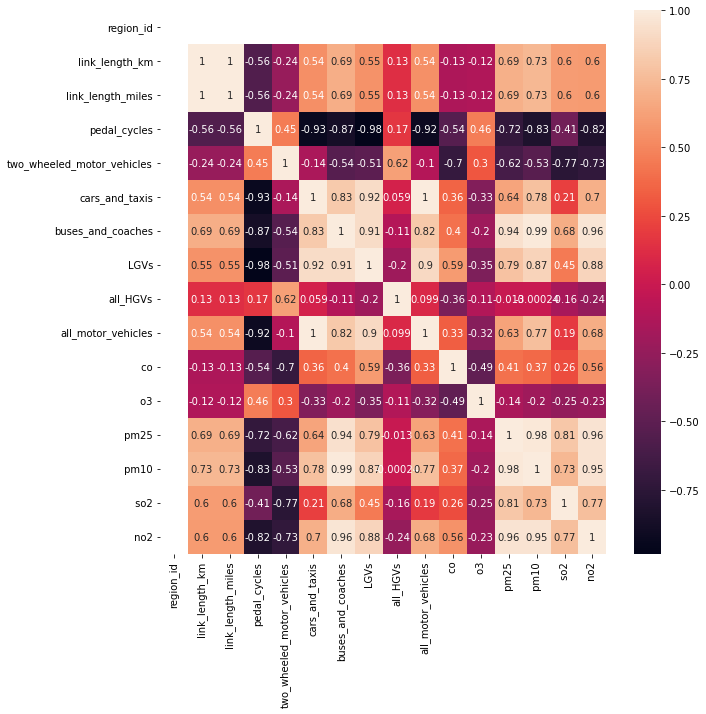

In [119]:
# Correlation matrix to check relationships between traffic data and air quality metrics
plt.figure(figsize=(10,10))
correlation_matrix = combined_df.drop(columns='year').corr()
sns.heatmap(correlation_matrix,annot=True)
plt.show()

***Multiple Regression Analysis: This tests how well the traffic variables (average speeds, traffic volume) predict changes in air quality. If the p-values of the traffic variables are below 0.05, we reject the null hypothesis and conclude that the traffic conditions significantly impact air quality.***

In [120]:
combined_df.columns

Index(['year', 'region_id', 'region_name', 'region_ons_code', 'link_length_km',
       'link_length_miles', 'pedal_cycles', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'LGVs', 'all_HGVs',
       'all_motor_vehicles', ' co', ' o3', ' pm25', ' pm10', ' so2', ' no2'],
      dtype='object')

In [121]:
# Define independent variables (traffic conditions)
X = combined_df['all_motor_vehicles']
# Add constant to the model (for intercept)
X = sm.add_constant(X)

# Dependent variables (air quality metrics)
for metric in [' pm25', ' pm10', ' o3', ' no2', ' so2', ' co']:
    # Define the dependent variable
    y = combined_df[metric]
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Print the summary of the regression model
    print(f"Regression results for {metric}:")
    print(model.summary())
    print("\n")

Regression results for  pm25:
                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     3.926
Date:                Thu, 10 Oct 2024   Prob (F-statistic):             0.0948
Time:                        21:36:58   Log-Likelihood:                -28.123
No. Observations:                   8   AIC:                             60.25
Df Residuals:                       6   BIC:                             60.41
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const 

C:\Users\dhind\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\dhind\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\dhind\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\dhind\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
C:\Users\dhind\anaconda3\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyw